<img src="https://raw.githubusercontent.com/dmlls/jizt/c2d7b9b81783e298d1898b5743b147d1faff8f29/images/JIZT-logo.svg" title="JIZT" alt="JIZT" width="230" align="left" style="margin-top:15px;margin-right:30px;" />

---

### Estudio del Número de Tókenes
[Diego Miguel Lozano](https://github.com/dmlls) \
GPL-3.0 License

*Última actualización: 8 de noviembre de 2020*

---

# Introducción

Este notebook lleva a cabo un análisis sobre las relaciones entre:
- Número de caracteres / Número de tókenes codificados
- Número de tókens (palabras + puntuación, sin codificar) / Número de tókenes codificados

El estudio se centra en los modelos `Bart` y `T5` implementados por la librería Hugging Face. Los textos empleados como ejemplo están en inglés, dado que estos modelos están optimizados para este idioma.

Si tras este análisis determinamos que estas relaciones no sufren grandes variaciones independientemente de la longitud del texto, esto nos permitirá realizar una división *a piori* del texto para ajustarlo a la longitud de entrada máxima de los modelos. Con división *a priori*, nos referimos a llevar a cabo una división del texto *antes* de codificarlo, ya que una vez codificado, perdemos la noción de "frase" y por tanto no podemos llevar a cabo una división que mantenga la coherencia y cohesión del texto, esto es, sin partir frases.

---

---


---

# Preprocesamiento del texto

Para el preprocesamiento del texto haremos uso de la función `preprocess_text` explicada en detalle en el jupyter notebook llamado "Preprocesamiento del texto".

In [1]:
from nltk.tokenize import RegexpTokenizer
from nltk import sent_tokenize

def preprocess_text(text, tokenizer=None, return_as_list=False):
    if tokenizer is None:
        # if next letter after period is lowercase, consider it part of the same sentence
        # ex: "As we can see in Figure 1.1. the sentence will not be split."
        tokenizer = RegexpTokenizer(r'[^.!?]+[.!?]+[^A-Z]*')
        if text[-1] != '.': # if there's not final period, add it so the regex matches the last sentence
            text += '.'
    
    text = ' '.join(text.split()) # remove '\n', '\t', etc.
    
    sentences = ' '.join(tokenizer.tokenize(text)).replace('  ', ' ') # ensure there's 1 whitespace at most

    sentences = sent_tokenize(sentences)

    final_sentences = [sentences[0]]
    
    for sent in sentences[1:]:
        # if the previous sentence doesn't end with a '.', '!' or '?' we concatenate the current sentence to it
        if final_sentences[-1][-1] != '.' and final_sentences[-1][-1] != '!' and final_sentences[-1][-1] != '?':
            final_sentences[-1] += ' ' + sent
        # if the next sentence doesn't start with a letter or a number, concatenate it to the previous
        elif not sent[0].isalpha() and not sent[0].isdigit():
            final_sentences[-1] += sent
        else:
            final_sentences.append(sent)
                                       
    return final_sentences if return_as_list else ' '.join(final_sentences)

---

---

---

# Textos [<sup>1</sup>](#fn1)
<span id="fn1">[<sup>1</sup>](#fn1) (extraídos de hilos reales de Twitter)</span>

Definamos una pequeña función para importar los textos desde ficheros .txt.

In [7]:
import os, os.path

def read_texts(texts_dir='./texts', texts_base_filename='text_', texts_extension='.txt'):
    """Reads all files in the specified directory into a list of strings."""
    
    # get number of texts matching texts_base_filename
    n_texts = len([name for name in os.listdir(texts_dir) \
                   if os.path.isfile(os.path.join(texts_dir, name)) and
                          name[:len(texts_base_filename)] == texts_base_filename])

    texts = []

    for i in range(1, n_texts + 1):
        with open(texts_dir + '/' + texts_base_filename + str(i) + texts_extension, 'r') as file:
            texts.append(file.read())
    
    return texts

In [8]:
texts = read_texts()

In [9]:
# example

texts[1]

"Man really in the mood to draw some kind of sad 'symbolism' with Sharon\n\nBasically I had this idea that you see two other 'Sharons' with this very creepy grin and they backstab the original. \n\nAnd after that you see a third show up. Sharon in her demon form. The demon form--\n--'swallows' her. And Sharon keeps falling down. Seeing all of the people she's lost in the position she saw them in last. So if for example one of them had been st*bbed you'd see them like that.\n\nThey then start to chant to her some very horrible things. But... they've never--\n--even said such things to her. Those horrible things they keep chanting are her own thoughts she keeps telling herself because of all the guilt she feels.\n\nAnd then when she reaches the last person she had lost. Her childhood friend. (He was the only one not k*lled. He was--\n--being t0rtured by her 'clone' to make him start fearing Sharon so he'd run away.) \n\nShe finally wakes up from the nightmare crying and screaming.\n\nBas

In [10]:
articles = read_texts(texts_base_filename='article_')

In [11]:
#example

articles[0][:579]

'On Witness and Respair: A Personal Tragedy Followed by Pandemic - Jesmyn Ward\n\nMy Beloved died in January. He was a foot taller than me and had large, beautiful dark eyes and dexterous, kind hands. He fixed me breakfast and pots of loose-leaf tea every morning. He cried at both of our children’s births, silently, tears glazing his face. Before I drove our children to school in the pale dawn light, he would put both hands on the top of his head and dance in the driveway to make the kids laugh. He was funny, quick-witted, and could inspire the kind of laughter that cramped m'

---

---

---

# Análisis

Como vamos a utilizar textos más largos que la máxima longitud de secuencia admitida por los tokenizadores usados, obtendremos *warnings* al realizar la codificación de los textos como el siguiente:

`Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors`

En nuestro caso, somos conscientes de este hecho, porque en este momento solo estamos interesados en conocer el número de tókens genereados, aún no vamos a pasar esos tókens codificados al modelo.

Por ello, vamos a desactivar estos *warnings* para aumentar la claridad de las ejecuciones.

In [12]:
import logging

# deactivate warnings from the tokenizers
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

Una vez hecho esto, podemos comenzar con el análisis.

---

## Hilos de Twitter

### Número de caracteres / Número de tókenes codificados

In [13]:
def char_count(string):
    """Counts the characters in a string."""
    
    return len(string)

In [14]:
def ratio_to_codified_tokens(text, count_function, tokenizer):
    """Calculates the ratio between certain count and the number of codified tokens.
    
    Args:
        text:
            Text to be analysed.
        count_function:
            Way of calculating the count on the text.
        tokenizer:
            Tokenizer model used to encode the text.
        
    Returns:
        The ratio calculated, the number returned by count_function and the
        number of encoded tokens.
    """

    count = count_function(text)
    n_enc_tokens = len(tokenizer.encode(text))
    
    return count/n_enc_tokens, count, n_enc_tokens

In [15]:
import numpy as np

def print_ratio(texts, count_function, count_description, tokenizer):
    """Prints the ratio between certain count and the number of codified tokens.
    
    Args:
        texts:
            List of texts to be analysed.
        count_function:
            Way of calculating the count on the text.
        count_description:
            String explaining what the count_function refers to.
        tokenizer:
            Tokenizer model used to encode the text.
    """
    
    count_dict = dict()
    ratios = []

    for i in range(len(texts)):
        ratio, count, n_enc_tokens = ratio_to_codified_tokens(texts[i], count_function, tokenizer)
        count_dict[i+1] = count
        ratios.append(ratio)
        print(f"Text {i+1}:")
        print(f"  {'N. ' + count_description + ':' : <20} {count}")
        print(f"  {'N. encoded tokens:' : <20} {n_enc_tokens}")
        print(f"  {'Ratio (char/tokens):' : <20} {ratio}\n")
    
    print(f"\nMinimum: (ratios): {np.min(ratios)}\n")
    print(f"Maximum (ratios): {np.max(ratios)}\n")
    print(f"Average (ratios): {np.mean(ratios)}\n")
    print(f"Std. deviation (ratios): {np.std(ratios)}\n")

---

#### Modelo T5-base

In [16]:
from transformers import T5Tokenizer

t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')

In [18]:
print_ratio(texts, char_count, 'characters', t5_tokenizer)

Text 1:
  N. characters:       925
  N. encoded tokens:   223
  Ratio (char/tokens): 4.147982062780269

Text 2:
  N. characters:       1025
  N. encoded tokens:   280
  Ratio (char/tokens): 3.6607142857142856

Text 3:
  N. characters:       1222
  N. encoded tokens:   306
  Ratio (char/tokens): 3.9934640522875817

Text 4:
  N. characters:       1224
  N. encoded tokens:   393
  Ratio (char/tokens): 3.114503816793893

Text 5:
  N. characters:       1662
  N. encoded tokens:   452
  Ratio (char/tokens): 3.6769911504424777

Text 6:
  N. characters:       2336
  N. encoded tokens:   552
  Ratio (char/tokens): 4.231884057971015

Text 7:
  N. characters:       2562
  N. encoded tokens:   591
  Ratio (char/tokens): 4.33502538071066

Text 8:
  N. characters:       2637
  N. encoded tokens:   665
  Ratio (char/tokens): 3.9654135338345866

Text 9:
  N. characters:       2706
  N. encoded tokens:   681
  Ratio (char/tokens): 3.973568281938326

Text 10:
  N. characters:       2972
  N. encoded tok

---

#### Modelo bart-base

In [19]:
from transformers import BartTokenizer

bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

In [20]:
print_ratio(texts, char_count, 'characters', bart_tokenizer)

Text 1:
  N. characters:       925
  N. encoded tokens:   213
  Ratio (char/tokens): 4.342723004694836

Text 2:
  N. characters:       1025
  N. encoded tokens:   257
  Ratio (char/tokens): 3.9883268482490273

Text 3:
  N. characters:       1222
  N. encoded tokens:   327
  Ratio (char/tokens): 3.7370030581039755

Text 4:
  N. characters:       1224
  N. encoded tokens:   373
  Ratio (char/tokens): 3.2815013404825737

Text 5:
  N. characters:       1662
  N. encoded tokens:   426
  Ratio (char/tokens): 3.9014084507042255

Text 6:
  N. characters:       2336
  N. encoded tokens:   514
  Ratio (char/tokens): 4.544747081712062

Text 7:
  N. characters:       2562
  N. encoded tokens:   599
  Ratio (char/tokens): 4.277128547579299

Text 8:
  N. characters:       2637
  N. encoded tokens:   626
  Ratio (char/tokens): 4.212460063897764

Text 9:
  N. characters:       2706
  N. encoded tokens:   677
  Ratio (char/tokens): 3.9970457902511076

Text 10:
  N. characters:       2972
  N. encoded t

---

### Número de tókens (palabras + puntuación, sin codificar) / Número de tókenes codificados

In [21]:
from nltk import word_tokenize

def token_count(string):
    """Counts the tokens in a string.
    
    A token can be either a word or a punctuation mark.
    """
    
    return len(word_tokenize(string))

---

#### Modelo T5-base

In [22]:
print_ratio(texts, token_count, 'tokens', t5_tokenizer)

Text 1:
  N. tokens:           187
  N. encoded tokens:   223
  Ratio (char/tokens): 0.8385650224215246

Text 2:
  N. tokens:           223
  N. encoded tokens:   280
  Ratio (char/tokens): 0.7964285714285714

Text 3:
  N. tokens:           300
  N. encoded tokens:   306
  Ratio (char/tokens): 0.9803921568627451

Text 4:
  N. tokens:           250
  N. encoded tokens:   393
  Ratio (char/tokens): 0.6361323155216285

Text 5:
  N. tokens:           359
  N. encoded tokens:   452
  Ratio (char/tokens): 0.7942477876106194

Text 6:
  N. tokens:           442
  N. encoded tokens:   552
  Ratio (char/tokens): 0.8007246376811594

Text 7:
  N. tokens:           477
  N. encoded tokens:   591
  Ratio (char/tokens): 0.8071065989847716

Text 8:
  N. tokens:           575
  N. encoded tokens:   665
  Ratio (char/tokens): 0.8646616541353384

Text 9:
  N. tokens:           541
  N. encoded tokens:   681
  Ratio (char/tokens): 0.7944199706314243

Text 10:
  N. tokens:           551
  N. encoded tokens

---

#### Modelo bart-base

In [23]:
print_ratio(texts, token_count, 'tokens', bart_tokenizer)

Text 1:
  N. tokens:           187
  N. encoded tokens:   213
  Ratio (char/tokens): 0.8779342723004695

Text 2:
  N. tokens:           223
  N. encoded tokens:   257
  Ratio (char/tokens): 0.867704280155642

Text 3:
  N. tokens:           300
  N. encoded tokens:   327
  Ratio (char/tokens): 0.9174311926605505

Text 4:
  N. tokens:           250
  N. encoded tokens:   373
  Ratio (char/tokens): 0.6702412868632708

Text 5:
  N. tokens:           359
  N. encoded tokens:   426
  Ratio (char/tokens): 0.8427230046948356

Text 6:
  N. tokens:           442
  N. encoded tokens:   514
  Ratio (char/tokens): 0.8599221789883269

Text 7:
  N. tokens:           477
  N. encoded tokens:   599
  Ratio (char/tokens): 0.7963272120200334

Text 8:
  N. tokens:           575
  N. encoded tokens:   626
  Ratio (char/tokens): 0.9185303514376997

Text 9:
  N. tokens:           541
  N. encoded tokens:   677
  Ratio (char/tokens): 0.7991137370753324

Text 10:
  N. tokens:           551
  N. encoded tokens:

---
---
---

## Artículos

### Número de caracteres / Número de tókenes codificados

#### Modelo t5-base

In [24]:
print_ratio(articles, char_count, 'characters', t5_tokenizer)

Text 1:
  N. characters:       12080
  N. encoded tokens:   3105
  Ratio (char/tokens): 3.890499194847021

Text 2:
  N. characters:       26974
  N. encoded tokens:   6770
  Ratio (char/tokens): 3.9843426883308717

Text 3:
  N. characters:       27655
  N. encoded tokens:   7056
  Ratio (char/tokens): 3.919359410430839

Text 4:
  N. characters:       51945
  N. encoded tokens:   13658
  Ratio (char/tokens): 3.803265485429785

Text 5:
  N. characters:       91654
  N. encoded tokens:   20911
  Ratio (char/tokens): 4.38305198221032

Text 6:
  N. characters:       118637
  N. encoded tokens:   29087
  Ratio (char/tokens): 4.078694949633857


Minimum: (ratios): 3.803265485429785

Maximum (ratios): 4.38305198221032

Average (ratios): 4.0098689518137824

Std. deviation (ratios): 0.18698497736485375



---

#### Modelo bart-base

In [25]:
print_ratio(articles, char_count, 'characters', bart_tokenizer)

Text 1:
  N. characters:       12080
  N. encoded tokens:   2897
  Ratio (char/tokens): 4.169830859509838

Text 2:
  N. characters:       26974
  N. encoded tokens:   5965
  Ratio (char/tokens): 4.522045264040234

Text 3:
  N. characters:       27655
  N. encoded tokens:   6917
  Ratio (char/tokens): 3.99812057250253

Text 4:
  N. characters:       51945
  N. encoded tokens:   12324
  Ratio (char/tokens): 4.214946445959105

Text 5:
  N. characters:       91654
  N. encoded tokens:   19700
  Ratio (char/tokens): 4.65248730964467

Text 6:
  N. characters:       118637
  N. encoded tokens:   27922
  Ratio (char/tokens): 4.248871857316811


Minimum: (ratios): 3.99812057250253

Maximum (ratios): 4.65248730964467

Average (ratios): 4.301050384828865

Std. deviation (ratios): 0.22040423876930862



---

### Número de tókens (palabras + puntuación, sin codificar) / Número de tókenes codificados

#### Modelo T5-base

In [26]:
print_ratio(articles, token_count, 'tokens', t5_tokenizer)

Text 1:
  N. tokens:           2562
  N. encoded tokens:   3105
  Ratio (char/tokens): 0.8251207729468599

Text 2:
  N. tokens:           5310
  N. encoded tokens:   6770
  Ratio (char/tokens): 0.7843426883308715

Text 3:
  N. tokens:           5888
  N. encoded tokens:   7056
  Ratio (char/tokens): 0.8344671201814059

Text 4:
  N. tokens:           10824
  N. encoded tokens:   13658
  Ratio (char/tokens): 0.7925025626006736

Text 5:
  N. tokens:           17055
  N. encoded tokens:   20911
  Ratio (char/tokens): 0.8155994452680407

Text 6:
  N. tokens:           24119
  N. encoded tokens:   29087
  Ratio (char/tokens): 0.8292020490253378


Minimum: (ratios): 0.7843426883308715

Maximum (ratios): 0.8344671201814059

Average (ratios): 0.8135391063921983

Std. deviation (ratios): 0.01878233448332706



---

#### Modelo T5-base

In [28]:
print_ratio(articles, token_count, 'tokens', bart_tokenizer)

Text 1:
  N. tokens:           2562
  N. encoded tokens:   2897
  Ratio (char/tokens): 0.8843631342768381

Text 2:
  N. tokens:           5310
  N. encoded tokens:   5965
  Ratio (char/tokens): 0.8901927912824812

Text 3:
  N. tokens:           5888
  N. encoded tokens:   6917
  Ratio (char/tokens): 0.8512360850079514

Text 4:
  N. tokens:           10824
  N. encoded tokens:   12324
  Ratio (char/tokens): 0.878286270691334

Text 5:
  N. tokens:           17055
  N. encoded tokens:   19700
  Ratio (char/tokens): 0.865736040609137

Text 6:
  N. tokens:           24119
  N. encoded tokens:   27922
  Ratio (char/tokens): 0.8637991547883389


Minimum: (ratios): 0.8512360850079514

Maximum (ratios): 0.8901927912824812

Average (ratios): 0.8722689127760134

Std. deviation (ratios): 0.013294981971569714



---

## Todos los textos (hilos + artículos)

In [41]:
all_texts = texts + articles

# sort the texts so they are in order by number of characters
txt = all_texts.pop(25)
all_texts = all_texts[:22] + [txt] + all_texts[23:]

### Número de caracteres / Número de tókenes codificados

#### Modelo T5-base

In [42]:
print_ratio(all_texts, char_count, 'characters', t5_tokenizer)

Text 1:
  N. characters:       925
  N. encoded tokens:   223
  Ratio (char/tokens): 4.147982062780269

Text 2:
  N. characters:       1025
  N. encoded tokens:   280
  Ratio (char/tokens): 3.6607142857142856

Text 3:
  N. characters:       1222
  N. encoded tokens:   306
  Ratio (char/tokens): 3.9934640522875817

Text 4:
  N. characters:       1224
  N. encoded tokens:   393
  Ratio (char/tokens): 3.114503816793893

Text 5:
  N. characters:       1662
  N. encoded tokens:   452
  Ratio (char/tokens): 3.6769911504424777

Text 6:
  N. characters:       2336
  N. encoded tokens:   552
  Ratio (char/tokens): 4.231884057971015

Text 7:
  N. characters:       2562
  N. encoded tokens:   591
  Ratio (char/tokens): 4.33502538071066

Text 8:
  N. characters:       2637
  N. encoded tokens:   665
  Ratio (char/tokens): 3.9654135338345866

Text 9:
  N. characters:       2706
  N. encoded tokens:   681
  Ratio (char/tokens): 3.973568281938326

Text 10:
  N. characters:       2972
  N. encoded tok

---

#### Modelo Bart-base

In [43]:
print_ratio(all_texts, char_count, 'characters', bart_tokenizer)

Text 1:
  N. characters:       925
  N. encoded tokens:   213
  Ratio (char/tokens): 4.342723004694836

Text 2:
  N. characters:       1025
  N. encoded tokens:   257
  Ratio (char/tokens): 3.9883268482490273

Text 3:
  N. characters:       1222
  N. encoded tokens:   327
  Ratio (char/tokens): 3.7370030581039755

Text 4:
  N. characters:       1224
  N. encoded tokens:   373
  Ratio (char/tokens): 3.2815013404825737

Text 5:
  N. characters:       1662
  N. encoded tokens:   426
  Ratio (char/tokens): 3.9014084507042255

Text 6:
  N. characters:       2336
  N. encoded tokens:   514
  Ratio (char/tokens): 4.544747081712062

Text 7:
  N. characters:       2562
  N. encoded tokens:   599
  Ratio (char/tokens): 4.277128547579299

Text 8:
  N. characters:       2637
  N. encoded tokens:   626
  Ratio (char/tokens): 4.212460063897764

Text 9:
  N. characters:       2706
  N. encoded tokens:   677
  Ratio (char/tokens): 3.9970457902511076

Text 10:
  N. characters:       2972
  N. encoded t

---

### Número de tókens (palabras + puntuación, sin codificar) / Número de tókenes codificados

#### Modelo T5-base

In [44]:
print_ratio(all_texts, token_count, 'tokens', t5_tokenizer)

Text 1:
  N. tokens:           187
  N. encoded tokens:   223
  Ratio (char/tokens): 0.8385650224215246

Text 2:
  N. tokens:           223
  N. encoded tokens:   280
  Ratio (char/tokens): 0.7964285714285714

Text 3:
  N. tokens:           300
  N. encoded tokens:   306
  Ratio (char/tokens): 0.9803921568627451

Text 4:
  N. tokens:           250
  N. encoded tokens:   393
  Ratio (char/tokens): 0.6361323155216285

Text 5:
  N. tokens:           359
  N. encoded tokens:   452
  Ratio (char/tokens): 0.7942477876106194

Text 6:
  N. tokens:           442
  N. encoded tokens:   552
  Ratio (char/tokens): 0.8007246376811594

Text 7:
  N. tokens:           477
  N. encoded tokens:   591
  Ratio (char/tokens): 0.8071065989847716

Text 8:
  N. tokens:           575
  N. encoded tokens:   665
  Ratio (char/tokens): 0.8646616541353384

Text 9:
  N. tokens:           541
  N. encoded tokens:   681
  Ratio (char/tokens): 0.7944199706314243

Text 10:
  N. tokens:           551
  N. encoded tokens

---

#### Modelo Bart-base

In [46]:
print_ratio(all_texts, token_count, 'tokens', bart_tokenizer)

Text 1:
  N. tokens:           187
  N. encoded tokens:   213
  Ratio (char/tokens): 0.8779342723004695

Text 2:
  N. tokens:           223
  N. encoded tokens:   257
  Ratio (char/tokens): 0.867704280155642

Text 3:
  N. tokens:           300
  N. encoded tokens:   327
  Ratio (char/tokens): 0.9174311926605505

Text 4:
  N. tokens:           250
  N. encoded tokens:   373
  Ratio (char/tokens): 0.6702412868632708

Text 5:
  N. tokens:           359
  N. encoded tokens:   426
  Ratio (char/tokens): 0.8427230046948356

Text 6:
  N. tokens:           442
  N. encoded tokens:   514
  Ratio (char/tokens): 0.8599221789883269

Text 7:
  N. tokens:           477
  N. encoded tokens:   599
  Ratio (char/tokens): 0.7963272120200334

Text 8:
  N. tokens:           575
  N. encoded tokens:   626
  Ratio (char/tokens): 0.9185303514376997

Text 9:
  N. tokens:           541
  N. encoded tokens:   677
  Ratio (char/tokens): 0.7991137370753324

Text 10:
  N. tokens:           551
  N. encoded tokens:

---
---
---

## Comparativa gráfica (hilos + artículos)

In [47]:
EXPORT_AS_PGF = False # set to False if you want to visualize the plots in the notebook

if EXPORT_AS_PGF:
    PLOTS_DIR = './exported_plots/'
    
    import matplotlib as mpl

    # Use the pgf backend (must be done before import pyplot interface)
    mpl.use('pgf')

    import matplotlib.pyplot as plt

    plt.style.use('ggplot')

    plt.rcParams.update({
        "font.family": "serif",  # use serif/main font for text elements
        "axes.labelsize": 13.5,    # fontsize of the x and y labels
        "xtick.labelsize": 12,   # fontsize of the xtick labels
        "ytick.labelsize": 12,   # fontsize of the ytick labels
        "text.usetex": True,     # use inline math for ticks
        "pgf.rcfonts": False     # don't setup fonts from rc parameters
        })
else:
    import matplotlib.pyplot as plt

In [48]:
def get_count_and_ratio(texts, count_function, tokenizer):
    """Calculates metrics over the texts.
    
    Args:
        texts:
            list of texts to analyse.
        count_function:
            function that calculates some metric, e.g. the number of
            characters of a text.
        tokenizer:
            model used for encoding the text.
    
    Returns:
        A list containing tuples with the metric calculated by count_function
        and the number of codified tokens, e.g. [(925, 213), (1025, 257), ...].
    """
    
    counts = []
    
    for txt in texts:
        ratio, count, _ = ratio_to_codified_tokens(txt, count_function, tokenizer)
        counts.append((count, ratio))
    
    return counts

In [49]:
def plot_results(texts, count_function, tokenizer, xlabel, ylabel, filename=None, export=True):
    """Plots the results of the analysis."""

    counts = get_count_and_ratio(texts, count_function, tokenizer)

    n_characters = np.array(counts, dtype=np.int64)[:,0] # first column
    n_encoded_tokens = np.array(counts)[:,1] # second column

    y_pos = np.arange(len(n_characters))

    plt.figure(figsize=(12, 4))

    plt.bar(y_pos, n_encoded_tokens, align='center', color="darkorange", alpha=0.8)
    plt.xticks(y_pos, n_characters, rotation=90)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.plot(y_pos, [np.mean(n_encoded_tokens)] * len(n_characters), "r-", linewidth=3)
    
    if export:
        plt.savefig(PLOTS_DIR + filename, bbox_inches='tight')
    else:
        plt.show()

---

### Número de caracteres / Número de tókenes codificados

#### Modelo T5-base

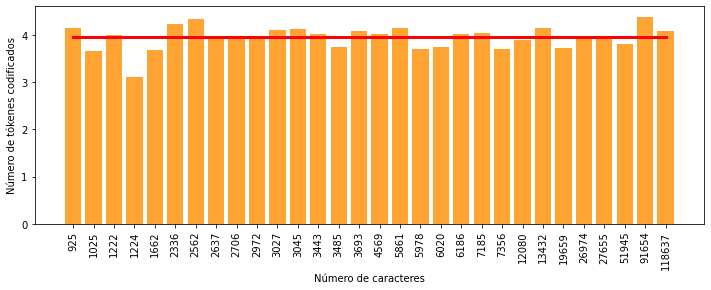

In [50]:
plot_results(all_texts,
             char_count,
             t5_tokenizer,
             xlabel='Número de caracteres',
             ylabel='Número de tókenes codificados',
             filename='t5-base-chars.pgf',
             export=EXPORT_AS_PGF)

#### Modelo bart-base

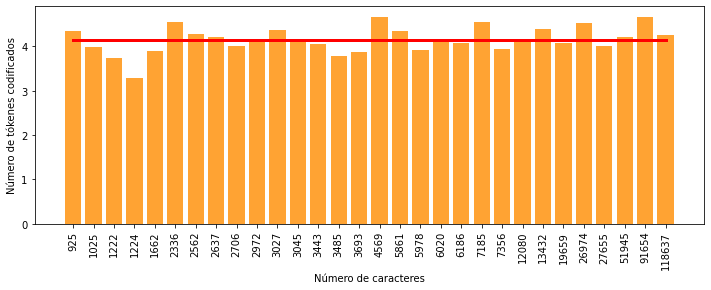

In [34]:
plot_results(all_texts,
             char_count,
             bart_tokenizer,
             xlabel='Número de caracteres',
             ylabel='Número de tókenes codificados',
             filename='bart-base-chars.pgf',
             export=EXPORT_AS_PGF)

---


### Número de tókens (palabras + puntuación, sin codificar) / Número de tókenes codificados

#### Modelo T5-base

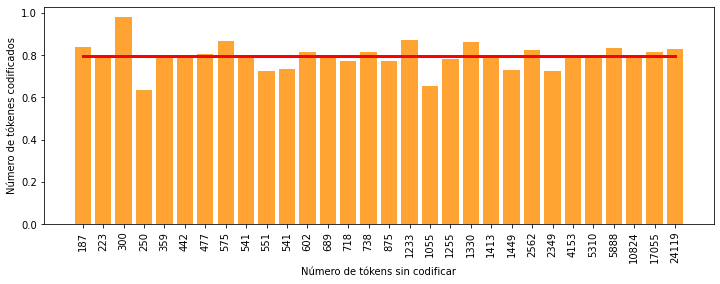

In [35]:
plot_results(all_texts,
             token_count,
             t5_tokenizer,
             xlabel='Número de tókens sin codificar',
             ylabel='Número de tókenes codificados',
             filename='t5-base-tokens.pgf',
             export=EXPORT_AS_PGF)

#### Modelo bart-base

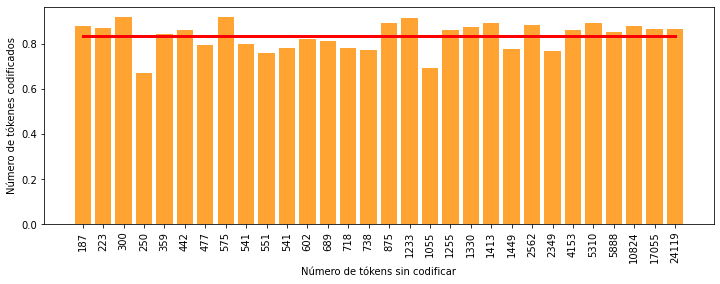

In [36]:
plot_results(all_texts,
             token_count,
             bart_tokenizer,
             xlabel='Número de tókens sin codificar',
             ylabel='Número de tókenes codificados',
             filename='bart-base-tokens.pgf',
             export=EXPORT_AS_PGF)

---

---

---